# 20211012-base-statistics
Evaluate IPCs, accuracy, and coverage over simpoints for the base prefetchers.

In [76]:
import os
import sys
import glob
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats
import attrdict
import matplotlib.pyplot as plt

from utils.load import load_simpoint_weights, parse_champsim_result_file, load_champsim_base_results, parse_paper_result_file

---
# User parameters.

You can look at the simpoint-weights or the data to get the trace_id for the trace you want.

In [77]:
traces = [
    '473.astar',
    '471.omnetpp',
    '429.mcf',
    '450.soplex',
    '482.sphinx3',
]

simpoints_dir = 'data/simpoint-weights/'
results_dir = 'data/base-prefetch1-fixedcache-500m/'
max_instruction_num = 500 # in millions
min_instruction_interval = 0 # in millions (this does not affect IPC results much)
verbose = False

---
# Load simpoint weights and results.

In [78]:
simpoint_weights = {}
for tr in traces:
    simpoint_weights[tr] = load_simpoint_weights(simpoints_dir, tr)

if verbose:
    print('Simpoint weights:')
    for tr in traces:
        print(f'{tr:12} : {simpoint_weights[tr]} largest = s{simpoint_weights[tr].argmax()}') # Why don't mcf weights add to 100?

In [79]:
results = {}
for tr in traces:
    base_data = []
    for i in range(len(simpoint_weights[tr])):
        base_data.append(load_champsim_base_results(
            results_dir, f'{tr}-s{i}', 
            max_instruction_num=max_instruction_num * 1000000,
            min_instruction_interval=int(min_instruction_interval * 1000000),
            verbose=verbose
        ))
    results[tr] = base_data

---
# Plotting / table helpers

**TODO** Break out into a utils file

In [80]:
def plot_results(data, title, y_label, subtitle=None, paper_data=None, factor = 1., ymin=None, ymax=None):
    """Plot data for a
    list of prefetchers and traces.
    """
    traces = list(data.keys())
    
    fig, ax = plt.subplots(dpi=128)
    #ax.grid()
    #ax.set_axisbelow(True) # Plot grid under bars.
    
    step_size = 0.1 if paper_data else 0.2
    width = 0.075 if paper_data else 0.15
    
    for i, tr in enumerate(traces):
        ax.bar(i, data[tr]['BO'] * 100., 
               color='C0', width = width, 
               label='BO' if i == 0 else ''
        )
        ax.bar(i + step_size, data[tr]['ISB'] * factor, 
               color='C1', width=width, 
               label='ISB' if i == 0 else ''
        )
        ax.bar(i + 2*step_size, data[tr]['ISB+BO'] * factor, 
               color='C2', width=width, 
               label='ISB + BO' if i == 0 else ''
        )
        if paper_data:
            ax.bar(i + 3*step_size, paper_data[tr]['Paper-BO'] * factor, 
                   color='C0', edgecolor='C0', alpha=0.25, width=width, 
                   label='Paper BO' if i == 0 else ''
            )
            ax.bar(i + 4*step_size, paper_data[tr]['Paper-ISB'] * factor, 
                   color='C1', edgecolor='C1', alpha=0.25, width=width, 
                   label='Paper ISB' if i == 0 else ''
            )
            ax.bar(i + 5*step_size, paper_data[tr]['Paper-Voyager'] * factor, 
                   color='C3', edgecolor='C3', alpha=0.25, width=width, 
                   label='Paper Voyager' if i == 0 else ''
            )
            
    ax.legend()
    ax.set_xticks(np.arange(0, len(traces)) + 0.2)
    ax.set_xticklabels(traces)
    if subtitle:
        title += f' ({subtitle})'
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_ylim(ymin=ymin, ymax=ymax)

In [81]:
def df_results(data, pop=[], factor=1., paper_data={}):
    data_ = {}
    for k in data.keys():
        data_[k] = {k_ : round(v * factor, 2) for k_, v in data[k].items()}
        for p in pop:
            data_[k].pop(p, None)
            
    paper_data_ = {}
    for k in paper_data.keys():
        paper_data_[k] = {k_ : round(v * factor, 2) for k_, v in paper_data[k].items()}
        for p in pop:
            paper_data_[k].pop(p, None)

    df = pd.DataFrame.from_dict(data_)
    df['Prefetcher'] = df.index
    pdf = pd.DataFrame.from_dict(paper_data_)
    pdf['Prefetcher'] = pdf.index
    df = df.merge(pdf, how='outer').set_index('Prefetcher')
    df.index.name = None
    return df

---
# IPC measurements
IPC = Instructions per cycle
- WGM: Take the weighted geometric mean of IPCs for the given trace, using the simpoint weights.
    - WGM Cumulative IPCs
    - WGM IPC speedup, vs no prefetcher
- Largest simpoint: Only consider IPC measurements from the longest (largest share) simpoint.
    - LS Cumulative IPCs
    - LS IPC speedup, vs no prefetcher
- **TODO**: Include Paper values

In [82]:
def get_simpoint_ipcs(results):
    """Parse the results dictionary to get an array
    of simpoint IPCs for each prefetcher. For prefetcher 
    p, simpoint_ipcs[p][i] is the cumulative IPC of p on
    simpoint s_i.
    """
    num_simpoints = len(results)
    simpoint_ipcs = defaultdict(lambda : np.zeros(num_simpoints, dtype=np.float32)) # Simpoint IPCs, indexed by prefetcher.
    for spidx, sp in enumerate(results):
        for pf in sp:
            # TODO handle missing / incomplete traces automatically 
            # (instead of using a debug if statement here to filter 
            # out unfinished runs)
            simpoint_ipcs[pf][spidx] = sp[pf].cumulative_ipcs[-1] 
    return simpoint_ipcs

def get_wgm_ipcs(results, simpoint_weights):
    """Calculate the weighted geometric mean cumulative IPC 
    of each prefetcher over the simpoints.
    """
    simpoint_ipcs = get_simpoint_ipcs(results)
    wgm_ipcs = {}
    for pf in simpoint_ipcs:
        wgm_ipcs[pf] = stats.mstats.gmean(simpoint_ipcs[pf], weights=simpoint_weights)
    return wgm_ipcs

def get_wgm_ipc_speedups(results, simpoint_weights, baseline_prefetcher='NoPrefetcher'):
    """Calcualte the weighted geometric mean cumulative IPC
    of each prefetcher, then get the relative IPC against the weighted 
    geometric mean of the baseline prefetcher, to get speedup.
    
    TODO - is the above method correct?
    """
    simpoint_ipcs = get_simpoint_ipcs(results)
    wgm_ipc_speedups = {}
    
    for pf in simpoint_ipcs:
        rel_ipcs = 1 + ((simpoint_ipcs[pf] - simpoint_ipcs[baseline_prefetcher])/simpoint_ipcs[baseline_prefetcher])
        wgm_rel_ipc = stats.mstats.gmean(rel_ipcs, weights=simpoint_weights)
        wgm_ipc_speedups[pf] = wgm_rel_ipc - 1.
    return wgm_ipc_speedups

def get_ls_ipcs(results, simpoint_weights):
    """Calculate the largest simpoint cumulative IPC
    of each prefetcher.
    """
    simpoint_ipcs = get_simpoint_ipcs(results)
    longest = np.argmax(simpoint_weights)
    ls_ipcs = {}
    for pf in simpoint_ipcs:
        ls_ipcs[pf] = simpoint_ipcs[pf][longest]
    return ls_ipcs
    
def get_ls_ipc_speedups(results, simpoint_weights, baseline_prefetcher='NoPrefetcher'):
    """Calculate the largest simpoint cumulative IPC speedup
    of each prefetcher.
    """
    simpoint_ipcs = get_simpoint_ipcs(results)
    longest = np.argmax(simpoint_weights)
    #print('Longest:', longest, simpoint_weights)
    ls_ipc_speedups = {}
    
    for pf in simpoint_ipcs:
        if pf == 'NoPrefetcher':
            continue
        ls_rel_ipc = 1 + ((simpoint_ipcs[pf][longest] - simpoint_ipcs[baseline_prefetcher][longest]) / simpoint_ipcs[baseline_prefetcher][longest])
        ls_ipc_speedups[pf] = ls_rel_ipc - 1
    return ls_ipc_speedups

In [83]:
wgm_ipcs, wgm_ipc_speedups = {}, {}
ls_ipcs, ls_ipc_speedups = {}, {}

for tr in traces:
    wgm_ipcs[tr] = get_wgm_ipcs(results[tr], simpoint_weights[tr])
    wgm_ipc_speedups[tr] = get_wgm_ipc_speedups(results[tr], simpoint_weights[tr])
    ls_ipcs[tr] = get_ls_ipcs(results[tr], simpoint_weights[tr])
    ls_ipc_speedups[tr] = get_ls_ipc_speedups(results[tr], simpoint_weights[tr])
    
paper_ipc_speedups = parse_paper_result_file('data/paper-values/paper_ipc_speedups.csv')

#### Cumulative IPCs

In [84]:
def plot_ipcs(ipcs, subtitle=None):
    """Plot (weighted geometric) mean IPCs for a
    list of prefetchers.
    """
    traces = list(ipcs.keys())
    
    fig, ax = plt.subplots(dpi=128)
    #ax.grid()
    #ax.set_axisbelow(True) # Plot grid under bars.
    
    for i, tr in enumerate(traces):
        ax.bar(i, ipcs[tr]['BO'], 
               color='C0', width = 0.075, 
               label='BO' if i == 0 else ''
        )
        ax.bar(i + 0.1, ipcs[tr]['ISB'], 
               color='C1', width=0.075, 
               label='ISB' if i == 0 else ''
        )
        ax.bar(i + 0.2, ipcs[tr]['ISB+BO'], 
               color='C2', width=0.075, 
               label='ISB + BO' if i == 0 else ''
        )
        ax.bar(i + 0.3, ipcs[tr]['NoPrefetcher'], 
               color='gray', edgecolor='gray', 
               alpha=0.3, width=0.075, 
               label='No prefetcher' if i == 0 else ''
        )
            
    ax.legend()
    ax.set_xticks(np.arange(0, len(traces)) + 0.15)
    ax.set_xticklabels(traces)
    title = 'Cumulative IPCs'
    if subtitle:
        title += f' ({subtitle})'
    ax.set_title(title)
    ax.set_ylabel('Cumulative IPC')
    ax.set_ylim(ymax=1.3)

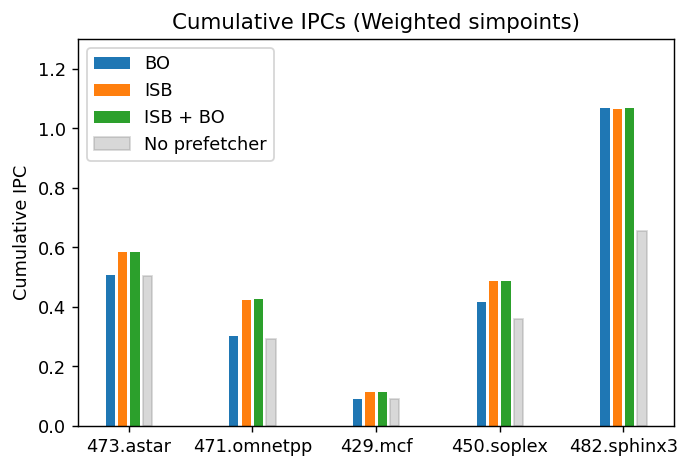

In [85]:
plot_ipcs(wgm_ipcs, subtitle='Weighted simpoints')

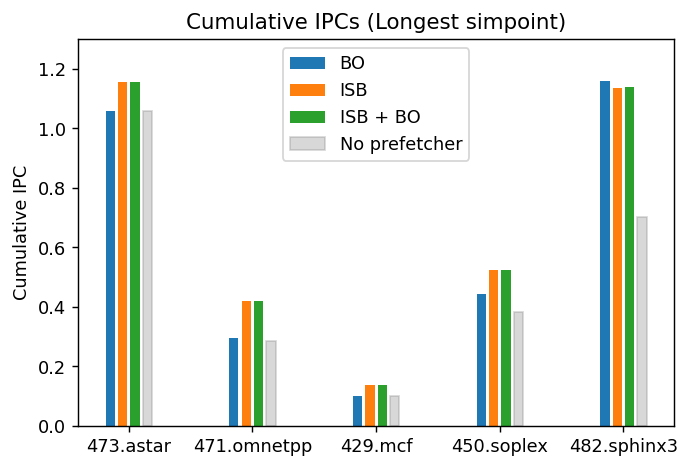

In [86]:
plot_ipcs(ls_ipcs, subtitle='Longest simpoint')

In [87]:
df_results(wgm_ipcs)

,473.astar,471.omnetpp,429.mcf,450.soplex,482.sphinx3
BO,0.51,0.30,0.09,0.42,1.07
NoPrefetcher,0.50,0.29,0.09,0.36,0.65
ISB,0.59,0.42,0.11,0.49,1.06
ISB+BO,0.59,0.42,0.11,0.49,1.07


In [88]:
df_results(ls_ipcs)

,473.astar,471.omnetpp,429.mcf,450.soplex,482.sphinx3
BO,1.06,0.29,0.10,0.44,1.16
NoPrefetcher,1.06,0.28,0.10,0.38,0.70
ISB,1.16,0.42,0.14,0.52,1.14
ISB+BO,1.16,0.42,0.14,0.52,1.14


#### IPC speedup (vs. no prefetcher)

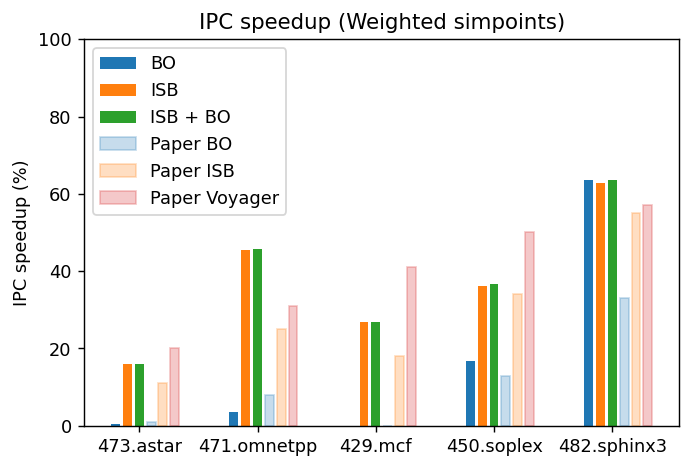

In [89]:
plot_results(
    wgm_ipc_speedups, 'IPC speedup', 'IPC speedup (%)', 
    subtitle='Weighted simpoints',
    factor=100,
    ymin=0, ymax=100,
    paper_data=paper_ipc_speedups
)

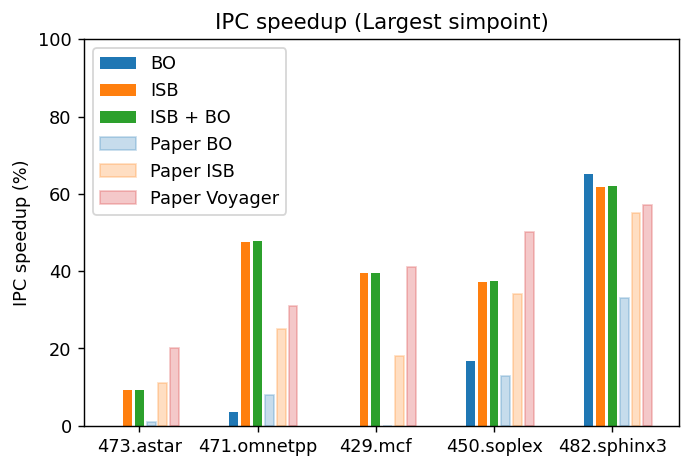

In [90]:
plot_results(
    ls_ipc_speedups, 'IPC speedup', 'IPC speedup (%)', 
    subtitle='Largest simpoint',
    factor=100,
    ymin=0, ymax=100,
    paper_data=paper_ipc_speedups
)

In [91]:
df_results(wgm_ipc_speedups, pop=['NoPrefetcher'], factor=100., paper_data=paper_ipc_speedups)

,473.astar,471.omnetpp,429.mcf,450.soplex,482.sphinx3
BO,0.38,3.50,0.00,16.72,63.67
ISB,16.05,45.40,26.94,36.28,62.86
ISB+BO,16.06,45.83,26.97,36.57,63.53
Paper-ISB,11.00,25.00,18.00,34.00,55.00
Paper-BO,1.00,8.00,0.00,13.00,33.00
Paper-Voyager,20.00,31.00,41.00,50.00,57.00


In [92]:
df_results(ls_ipc_speedups, pop=['NoPrefetcher'], factor=100., paper_data=paper_ipc_speedups)

,473.astar,471.omnetpp,429.mcf,450.soplex,482.sphinx3
BO,0.00,3.65,0.00,16.65,65.05
ISB,9.23,47.45,39.53,37.19,61.67
ISB+BO,9.23,47.90,39.57,37.47,62.15
Paper-ISB,11.00,25.00,18.00,34.00,55.00
Paper-BO,1.00,8.00,0.00,13.00,33.00
Paper-Voyager,20.00,31.00,41.00,50.00,57.00


---
# Accuracy measurements
Accuracy = useful / (useful + useless) prefetches
- WAM: Take the weighted arithmatic mean of accuracies for the given trace, using the simpoint weights.
- Largest simpoint: Only consider accuracy of the largest (highest-weighted) simpoint.

In [93]:
def get_simpoint_accuracies(results):
    """Parse the results dictionary to get an array
    of simpoint accuracies for each prefetcher. For prefetcher 
    p, simpoint_accs[p][i] is the accuracy of p on
    simpoint s_i.
    """
    num_simpoints = len(results)
    simpoint_accs = defaultdict(lambda : np.zeros(num_simpoints, dtype=np.float32)) # Simpoint IPCs, indexed by prefetcher.
    for spidx, sp in enumerate(results):
        for pf in sp:
            # TODO handle missing / incomplete traces automatically 
            # (instead of using a debug if statement here to filter 
            # out unfinished runs)
            simpoint_accs[pf][spidx] = sp[pf].accuracy
    return simpoint_accs

def get_wam_accuracies(results, simpoint_weights):
    """Calculate the weighted arithmatic mean accuracy 
    of each prefetcher over the simpoints.
    """
    simpoint_accs = get_simpoint_accuracies(results)
    wam_accs = {}
    for pf in simpoint_accs:
        if pf == 'NoPrefetcher':
            continue
        wam_accs[pf] = np.average(simpoint_accs[pf], weights=simpoint_weights)
    return wam_accs

def get_ls_accuracies(results, simpoint_weights):
    """Calculate the largest simpoint accuracy
    of each prefetcher.
    """
    simpoint_accs = get_simpoint_accuracies(results)
    longest = np.argmax(simpoint_weights)
    ls_accs = {}
    for pf in simpoint_accs:
        if pf == 'NoPrefetcher':
            continue
        ls_accs[pf] = simpoint_accs[pf][longest]
    return ls_accs

In [94]:
wam_accs = {}
ls_accs = {}

for tr in traces:
    wam_accs[tr] = get_wam_accuracies(results[tr], simpoint_weights[tr])
    print(f'WAM {tr:13} : {wam_accs[tr]}')
    ls_accs[tr] = get_ls_accuracies(results[tr], simpoint_weights[tr])
    print(f'LS  {tr:13} : {ls_accs[tr]}')

paper_accs = parse_paper_result_file('data/paper-values/paper_accuracies.csv')

WAM 473.astar     : {'BO': 0.11085797327472142, 'ISB': 0.11757097743808595, 'ISB+BO': 0.11762141351886678}
LS  473.astar     : {'BO': 0.0, 'ISB': 0.105844215, 'ISB+BO': 0.105844215}
WAM 471.omnetpp   : {'BO': 0.7315725312349636, 'ISB': 0.1039441944290644, 'ISB+BO': 0.12752368911153378}
LS  471.omnetpp   : {'BO': 0.7247495, 'ISB': 0.10834789, 'ISB+BO': 0.13295552}
WAM 429.mcf       : {'BO': 0.14610011875629425, 'ISB': 0.29257056428133094, 'ISB+BO': 0.29239469425752485}
LS  429.mcf       : {'BO': 0.29220024, 'ISB': 0.231825, 'ISB+BO': 0.2315928}
WAM 450.soplex    : {'BO': 0.35974796798186426, 'ISB': 0.12642262222557002, 'ISB+BO': 0.12958478826485306}
LS  450.soplex    : {'BO': 0.37110355, 'ISB': 0.110962726, 'ISB+BO': 0.115328796}
WAM 482.sphinx3   : {'BO': 0.1603550740121883, 'ISB': 0.028498619101208936, 'ISB+BO': 0.03383749740130728}
LS  482.sphinx3   : {'BO': 0.12645002, 'ISB': 0.022668831, 'ISB+BO': 0.028276376}


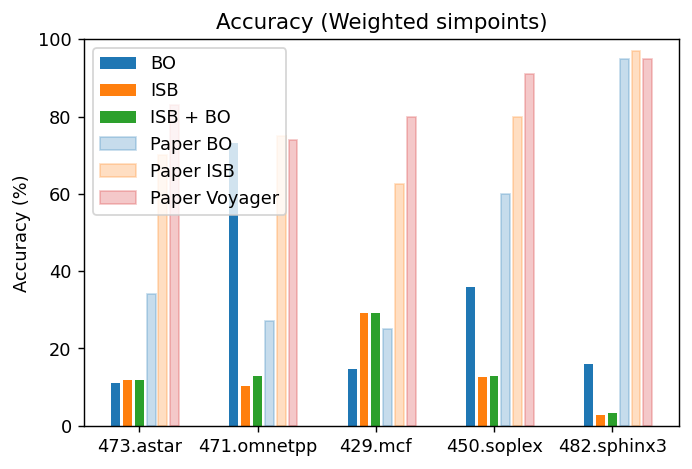

In [95]:
plot_results(
    wam_accs, 'Accuracy', 'Accuracy (%)', 
    subtitle='Weighted simpoints',
    factor=100,
    ymin=0, ymax=100,
    paper_data=paper_accs
)

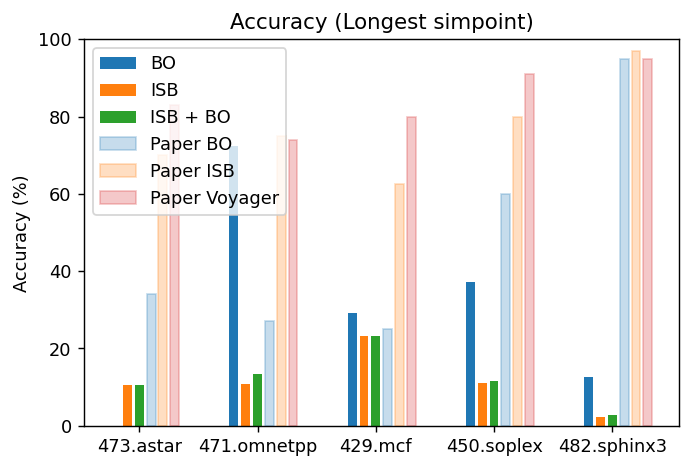

In [96]:
plot_results(
    ls_accs, 'Accuracy', 'Accuracy (%)', 
    subtitle='Longest simpoint',
    factor=100,
    ymin=0, ymax=100,
    paper_data=paper_accs
)

In [97]:
df_results(wam_accs, factor=100.)

,473.astar,471.omnetpp,429.mcf,450.soplex,482.sphinx3
BO,11.09,73.16,14.61,35.97,16.04
ISB,11.76,10.39,29.26,12.64,2.85
ISB+BO,11.76,12.75,29.24,12.96,3.38


In [98]:
df_results(ls_accs, factor=100.)

,473.astar,471.omnetpp,429.mcf,450.soplex,482.sphinx3
BO,0.00,72.47,29.22,37.11,12.65
ISB,10.58,10.83,23.18,11.10,2.27
ISB+BO,10.58,13.30,23.16,11.53,2.83


---
# Coverage measurements
Coverage = Percent decrease of:
- \# of LLC load + RFO misses on a prefetcher
- vs. # of LLC load + RFO misses on baseline (NoPrefetcher)
- WAM: Take the weighted arithmatic mean of coverages for the given trace, using the simpoint weights.
- Largest simpoint: Only consider coveraeg of the largest (highest-weighted) simpoint.

In [99]:
def get_simpoint_coverages(results, baseline_prefetcher='NoPrefetcher'):
    """Parse the results dictionary to get an array
    of simpoint coverages for each prefetcher. For prefetcher 
    p, simpoint_covs[p][i] is the coverage of p on
    simpoint s_i w.r.t. the baseline.
    """
    num_simpoints = len(results)
    simpoint_covs = defaultdict(lambda : np.zeros(num_simpoints, dtype=np.float32)) # Simpoint IPCs, indexed by prefetcher.
    for spidx, sp in enumerate(results):
        base_misses = sp[baseline_prefetcher].llc_load_misses + sp[baseline_prefetcher].llc_rfo_misses
        for pf in sp:
            pf_misses = sp[pf].llc_load_misses + sp[pf].llc_rfo_misses
            simpoint_covs[pf][spidx] = (base_misses - pf_misses) / base_misses
            #print(simpoint_covs[pf][spidx])
    return simpoint_covs

def get_wam_coverages(results, simpoint_weights, baseline_prefetcher='NoPrefetcher'):
    """Calculate the weighted arithmatic mean coverage 
    of each prefetcher over the simpoints.
    
    """
    simpoint_covs = get_simpoint_coverages(results, baseline_prefetcher)
    wam_covs = {}
    
    for pf in simpoint_covs:
        if pf == 'NoPrefetcher':
            continue
        wam_covs[pf] = np.average(simpoint_covs[pf], weights=simpoint_weights)
    return wam_covs

def get_ls_coverages(results, simpoint_weights, baseline_prefetcher='NoPrefetcher'):
    """Calculate the largest simpoint coverage
    of each prefetcher.
    """
    simpoint_covs = get_simpoint_coverages(results, baseline_prefetcher)
    longest = np.argmax(simpoint_weights)
    ls_covs = {}
    for pf in simpoint_covs:
        ls_covs[pf] = simpoint_covs[pf][longest]
    return ls_covs

In [100]:
wam_covs = {}
ls_covs = {}

for tr in traces:
    wam_covs[tr] = get_wam_coverages(results[tr], simpoint_weights[tr])
    print(f'WAM {tr:13} : {wam_covs[tr]}')
    ls_covs[tr] = get_ls_coverages(results[tr], simpoint_weights[tr])
    print(f'LS  {tr:13} : {ls_covs[tr]}')
    
paper_covs = parse_paper_result_file('data/paper-values/paper_coverages.csv')

WAM 473.astar     : {'BO': 0.01645686093182299, 'ISB': 0.3012637285505846, 'ISB+BO': 0.3017132620443571}
LS  473.astar     : {'BO': 0.0, 'NoPrefetcher': 0.0, 'ISB': 0.31130624, 'ISB+BO': 0.31130624}
WAM 471.omnetpp   : {'BO': 0.08039526512955833, 'ISB': 0.5857948308732637, 'ISB+BO': 0.5904867623233081}
LS  471.omnetpp   : {'BO': 0.08527097, 'NoPrefetcher': 0.0, 'ISB': 0.6035704, 'ISB+BO': 0.6083139}
WAM 429.mcf       : {'BO': 1.5802315829205327e-05, 'ISB': 0.2957868278137697, 'ISB+BO': 0.2961276168661855}
LS  429.mcf       : {'BO': 3.160463e-05, 'NoPrefetcher': 0.0, 'ISB': 0.3940581, 'ISB+BO': 0.3946398}
WAM 450.soplex    : {'BO': 0.2808136125246865, 'ISB': 0.3429282092739525, 'ISB+BO': 0.3462311583384724}
LS  450.soplex    : {'BO': 0.2793302, 'NoPrefetcher': 0.0, 'ISB': 0.3438992, 'ISB+BO': 0.34702602}
WAM 482.sphinx3   : {'BO': 0.6173227757382952, 'ISB': 0.6013002004672366, 'ISB+BO': 0.6034181637446958}
LS  482.sphinx3   : {'BO': 0.6359282, 'NoPrefetcher': 0.0, 'ISB': 0.59770405, 'IS

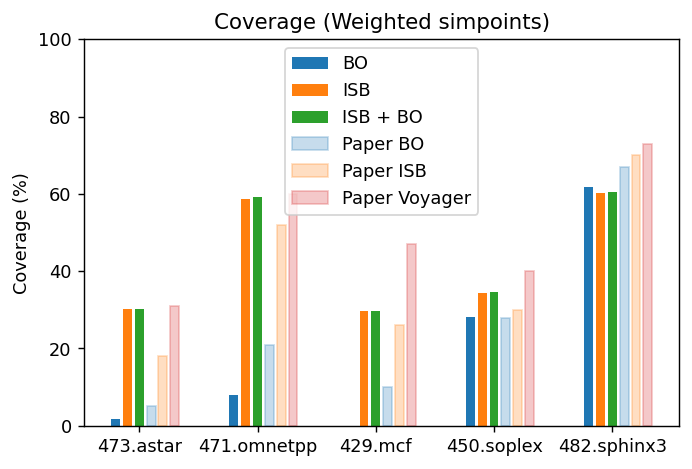

In [101]:
plot_results(
    wam_covs, 'Coverage', 'Coverage (%)',
    subtitle='Weighted simpoints',
    factor=100.,
    ymin=0, ymax=100,
    paper_data=paper_covs
)

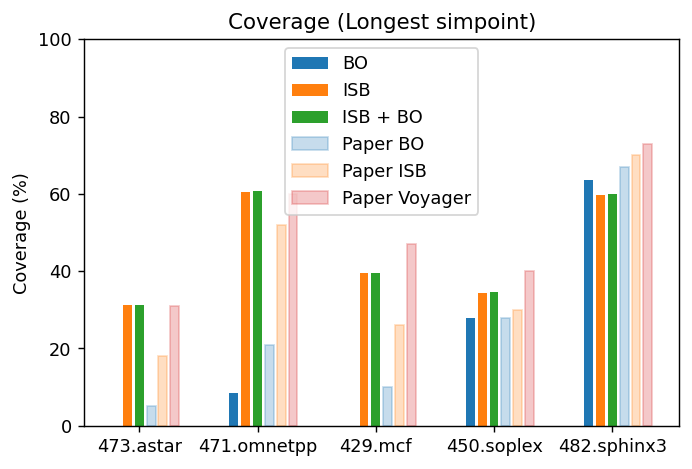

In [102]:
plot_results(
    ls_covs, 'Coverage', 'Coverage (%)',
    subtitle='Longest simpoint',
    factor=100.,
    ymin=0, ymax=100,
    paper_data=paper_covs
)

In [103]:
df_results(wam_covs, factor=100, pop=['NoPrefetcher'])

,473.astar,471.omnetpp,429.mcf,450.soplex,482.sphinx3
BO,1.65,8.04,0.00,28.08,61.73
ISB,30.13,58.58,29.58,34.29,60.13
ISB+BO,30.17,59.05,29.61,34.62,60.34


In [104]:
df_results(ls_covs, factor=100, pop=['NoPrefetcher'])

,473.astar,471.omnetpp,429.mcf,450.soplex,482.sphinx3
BO,0.00,8.53,0.00,27.93,63.59
ISB,31.13,60.36,39.41,34.39,59.77
ISB+BO,31.13,60.83,39.46,34.70,59.89


---
# Unified accuracy/coverage

In [105]:
def get_simpoint_uacs(results):
    """Parse the results dictionary to get an array
    of simpoint UACs for each prefetcher. For prefetcher 
    p, simpoint_uacs[p][i] is the UAC of p on
    simpoint s_i.
    """
    num_simpoints = len(results)
    simpoint_uacs = defaultdict(lambda : np.zeros(num_simpoints, dtype=np.float32)) # Simpoint IPCs, indexed by prefetcher.
    for spidx, sp in enumerate(results):
        for pf in sp:
            # TODO handle missing / incomplete traces automatically 
            # (instead of using a debug if statement here to filter 
            # out unfinished runs)
            simpoint_uacs[pf][spidx] = sp[pf].uac
    return simpoint_uacs

def get_wam_uacs(results, simpoint_weights):
    """Calculate the weighted arithmatic mean UAC 
    of each prefetcher over the simpoints.
    """
    simpoint_uacs = get_simpoint_uacs(results)
    wam_uacs = {}
    for pf in simpoint_uacs:
        if pf == 'NoPrefetcher':
            continue
        wam_uacs[pf] = np.average(simpoint_uacs[pf], weights=simpoint_weights)
    return wam_uacs

def get_ls_uacs(results, simpoint_weights):
    """Calculate the largest simpoint UAC
    of each prefetcher.
    """
    simpoint_uacs = get_simpoint_uacs(results)
    longest = np.argmax(simpoint_weights)
    ls_uacs = {}
    for pf in simpoint_uacs:
        if pf == 'NoPrefetcher':
            continue
        ls_uacs[pf] = simpoint_uacs[pf][longest]
    return ls_uacs

In [106]:
wam_uacs = {}
ls_uacs = {}

for tr in traces:
    wam_uacs[tr] = get_wam_uacs(results[tr], simpoint_weights[tr])
    print(f'WGM {tr:13} : {wam_uacs[tr]}')
    ls_uacs[tr] = get_ls_uacs(results[tr], simpoint_weights[tr])
    print(f'LS  {tr:13} : {ls_uacs[tr]}')
    
paper_uacs = parse_paper_result_file('data/paper-values/paper_uacs.csv')

WGM 473.astar     : {'BO': 0.008314320948305576, 'ISB': 0.31185863863286667, 'ISB+BO': 0.31180535702539247}
LS  473.astar     : {'BO': 0.0, 'ISB': 0.38503247, 'ISB+BO': 0.38503247}
WGM 471.omnetpp   : {'BO': 0.01827952966185625, 'ISB': 0.5450020629348017, 'ISB+BO': 0.5291178646749757}
LS  471.omnetpp   : {'BO': 0.018248338, 'ISB': 0.543187, 'ISB+BO': 0.5266679}
WGM 429.mcf       : {'BO': 0.0, 'ISB': 0.284000412590876, 'ISB+BO': 0.28385718334545657}
LS  429.mcf       : {'BO': 0.0, 'ISB': 0.39556447, 'ISB+BO': 0.3953068}
WGM 450.soplex    : {'BO': 0.030728928664468035, 'ISB': 0.26937159402486205, 'ISB+BO': 0.26721116898019454}
LS  450.soplex    : {'BO': 0.029288694, 'ISB': 0.2891915, 'ISB+BO': 0.2868336}
WGM 482.sphinx3   : {'BO': 0.17254733389818125, 'ISB': 0.6452406299212496, 'ISB+BO': 0.639928568456756}
LS  482.sphinx3   : {'BO': 0.16859205, 'ISB': 0.65944445, 'ISB+BO': 0.65419644}


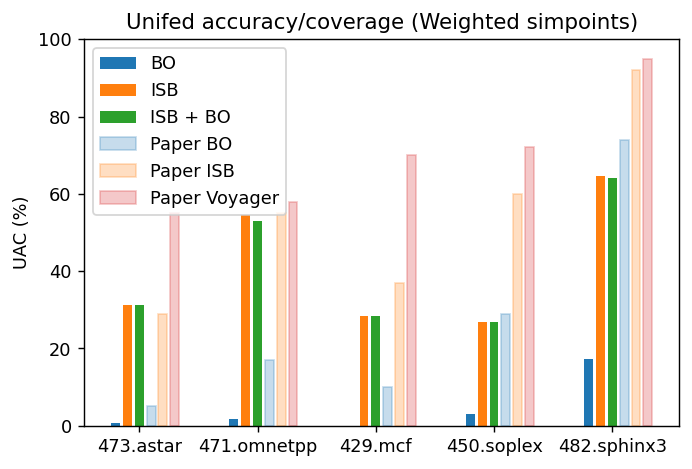

In [107]:
plot_results(
    wam_uacs, 'Unifed accuracy/coverage', 'UAC (%)',
    subtitle='Weighted simpoints',
    factor=100.,
    ymin=0, ymax=100,
    paper_data=paper_uacs
)

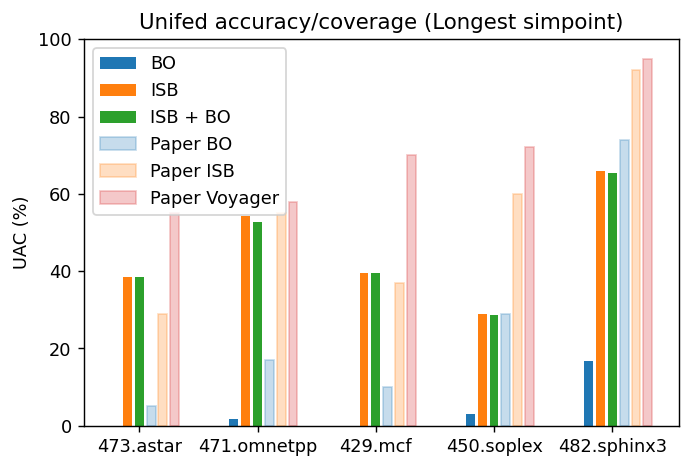

In [108]:
plot_results(
    ls_uacs, 'Unifed accuracy/coverage', 'UAC (%)',
    subtitle='Longest simpoint',
    factor=100.,
    ymin=0, ymax=100,
    paper_data=paper_uacs
)

In [109]:
df_results(wam_uacs, factor=100, pop=['NoPrefetcher'], paper_data=paper_uacs)

,473.astar,471.omnetpp,429.mcf,450.soplex,482.sphinx3
BO,0.83,1.83,0.00,3.07,17.25
ISB,31.19,54.50,28.40,26.94,64.52
ISB+BO,31.18,52.91,28.39,26.72,63.99
Paper-ISB,29.00,55.00,37.00,60.00,92.00
Paper-BO,5.00,17.00,10.00,29.00,74.00
Paper-Voyager,55.00,58.00,70.00,72.00,95.00


In [110]:
df_results(ls_uacs, factor=100, pop=['NoPrefetcher'], paper_data=paper_uacs)

,473.astar,471.omnetpp,429.mcf,450.soplex,482.sphinx3
BO,0.0,1.82,0.00,2.93,16.86
ISB,38.5,54.32,39.56,28.92,65.94
ISB+BO,38.5,52.67,39.53,28.68,65.42
Paper-ISB,29.0,55.00,37.00,60.00,92.00
Paper-BO,5.0,17.00,10.00,29.00,74.00
Paper-Voyager,55.0,58.00,70.00,72.00,95.00
